In [2]:
data_path = '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Salinas/'

In [15]:
import numpy as np
import visdom
import utils
import seaborn as sns
from datasets import get_dataset, HyperX
import os
from sklearn import preprocessing
from sklearn.decomposition import PCA, FastICA
import random

In [4]:
vis = visdom.Visdom()

Setting up a new session...


Exception in user code:
------------------------------------------------------------


Traceback (most recent call last):
  File "/home/oscar/anaconda3/lib/python3.7/site-packages/urllib3/connection.py", line 159, in _new_conn
    (self._dns_host, self.port), self.timeout, **extra_kw)
  File "/home/oscar/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 80, in create_connection
    raise err
  File "/home/oscar/anaconda3/lib/python3.7/site-packages/urllib3/util/connection.py", line 70, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 111] Connection refused

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/oscar/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 600, in urlopen
    chunked=chunked)
  File "/home/oscar/anaconda3/lib/python3.7/site-packages/urllib3/connectionpool.py", line 354, in _make_request
    conn.request(method, url, **httplib_request_kw)
  File "/home/oscar/anaconda3/lib/python3.7/http/client.py", line 1244, in requ

In [4]:
label_values = ["Undefined", "Brocoli_green_weeds_1", "Brocoli_green_weeds_2", "Fallow",
                        "Fallow_rough_plow", "Fallow_smooth", "Stubble",
                        "Celery", "Grapes_untrained", "Soil_vinyard_develop",
                        "Corn_senesced_green_weeds", "Lettuce_romaine_4wk", "Lettuce_romaine_5wk",
                        "Lettuce_romaine_6wk", "Lettuce_romaine_7wk", "Vinyard_untrained",
                        "Vinyard_vertical_trellis"]

palette = None
rgb_bands = (43, 21, 11)

if palette is None:
    # Generate color palette
    palette = {0: (0, 0, 0)}
    for k, color in enumerate(sns.color_palette("hls", len(label_values) - 1)):
        palette[k + 1] = tuple(np.asarray(255 * np.array(color), dtype='uint8'))
invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(x):
    return utils.convert_to_color_(x, palette=palette)
def convert_from_color(x):
    return utils.convert_from_color_(x, palette=invert_palette)

In [87]:
#train_patches = np.zeros(int((len(os.listdir(data_path + '/salinas_fold_0/'))-3)/2))
#train_gt = np.copy(train_patches)

train_patches = []
train_gt = []

for i in (range(int((len(os.listdir(data_path + '/salinas_fold_0/'))-3)/2))):
    #train_patches[i] = np.load(data_path + '/salinas_fold_0/patch_{}.npy'.format(i))
    #train_gt[i] = np.load(data_path + '/salinas_fold_0/patch_{}_gt.npy'.format(i))
    
    train_patches.append(np.load(data_path + '/salinas_fold_0/patch_{}.npy'.format(i)))
    train_gt.append(np.load(data_path + '/salinas_fold_0/patch_{}_gt.npy'.format(i)))

test = np.load(data_path + '/salinas_fold_0/test.npy')
test_gt = np.load(data_path + '/salinas_fold_0/test_gt.npy') 

In [ ]:
mask = np.ones_like(train_gt)
print(np.count_nonzero(mask))
for i in range(len(mask)):
    mask[i, train_gt[i] == 0] = 0
print(np.count_nonzero(mask))
p,x,y = np.nonzero(mask)
print(str(p) + ' ' + str(x) + '' + str(y))
p_u, x_u, y_u = np.nonzero(mask==0)

In [88]:
gt_np = np.array(train_gt)
train_np = np.array(train_patches)

In [ ]:
idx = set()

while len(idx) < 0.05*np.prod(gt_np.shape):
    p = np.random.randint(gt_np.shape[0])
    x = np.random.randint(gt_np.shape[1])
    y = np.random.randint(gt_np.shape[2])
    if (p,x,y) not in idx:
        idx.add((p,x,y))

In [ ]:
idx_np = np.array(list(idx))
idx_np

In [ ]:
train_np.shape

In [89]:
ignored_labels = [0]
patch_size = 5

pad_width = patch_size // 2

train_np = np.pad(train_np, ((0,0), (pad_width, pad_width), (pad_width, pad_width), (0,0)))
gt_np = np.pad(gt_np, ((0,0), (pad_width, pad_width), (pad_width, pad_width)))

In [91]:
mask = np.ones_like(gt_np)
for l in ignored_labels:
    mask[gt_np == l] = 0
patch_labeled, x_labeled, y_labeled = np.nonzero(mask)

for l in ignored_labels:
    patch_unlabeled, x_unlabeled, y_unlabeled = np.nonzero(mask==l)

p = patch_size // 2

indices_labeled = np.array([(p_l, x_l, y_l) for p_l, x_l, y_l in zip(patch_labeled, x_labeled, y_labeled) if x_l >= p and x_l < train_np.shape[1] - p and y_l >= p and y_l < train_np.shape[2] - p])
labels = [gt_np[p_l, x_l, y_l] for p_l, x_l, y_l in indices_labeled]

indices_unlabeled = np.array([(p_u, x_u, y_u) for p_u, x_u, y_u in zip(patch_unlabeled, x_unlabeled, y_unlabeled) if x_u >= p and x_u < train_np.shape[1] - p and y_u >= p and y_u < train_np.shape[2] - p])

indices_labeled_shuffle = np.copy(indices_labeled)
indices_unlabeled_shuffle = np.copy(indices_unlabeled)

np.random.shuffle(indices_labeled_shuffle)
np.random.shuffle(indices_unlabeled_shuffle)

In [ ]:
p, x, y = indices_labeled[0]

data = train_np[p, x-pad_width:x - pad_width + patch_size, y-pad_width:y-pad_width+patch_size]

label = gt_np[p, x-pad_width:x - pad_width + patch_size, y-pad_width:y-pad_width+patch_size]
labels[0]

In [ ]:
reshape = train_np.reshape(np.prod(train_np.shape[:3]), np.prod(train_np.shape[3:]))
scaler = preprocessing.MinMaxScaler()
reshape = scaler.fit_transform(reshape)
img_list = reshape.reshape(train_np.shape)

test = np.asarray(test, dtype='float32')
data_test = test.reshape(np.prod(test.shape[:2]), np.prod(test.shape[2:]))
data_test = scaler.transform(data_test)
test_patch = data_test.reshape(test.shape)

In [ ]:
np.max((test - np.min(train_np))/(np.max(train_np) - np.min(train_np)))

In [93]:
x_size = train_np[0].shape[0]
y_size = train_np[0].shape[1]
data_train = np.array([train_np[p_l, x_l, y_l] for p_l, x_l, y_l in zip(patch_labeled, x_labeled, y_labeled) if x_l >= p and x_l < x_size - p and y_l >= p and y_l < y_size - p])

    
    

In [ ]:
pca = PCA(n_components=11)
pca.fit(data_train)

In [ ]:
nalepa_classes = np.zeros(len(label_values))

for i in range(len(train_gt)):
    for c in range(len(nalepa_classes)):
        amount = np.count_nonzero(train_gt[i] == c)
        nalepa_classes[c] += amount

In [ ]:
print(nalepa_classes)

In [ ]:
print(np.sum(nalepa_classes[1:]))

In [ ]:
np.count_nonzero(gt_np) + np.count_nonzero(test_gt)

In [ ]:
np.shape(np.pad(train_patches, ((0,0), (2,2), (2,2), (0,0))))

In [ ]:
utils.display_predictions(convert_to_color(gt_5), vis)

In [ ]:
utils.display_dataset(patch_5, gt_5, rgb_bands, label_values, palette, vis)

In [5]:
img, gt, label_values, ignored_labels, rgb_bands, palette = get_dataset('Salinas', target_folder='/home/oscar/Desktop/Exjobb/Data/')

In [ ]:
img.shape[1]

In [ ]:
patch_size = 5

In [ ]:
x = 0
y = 0

patch_list = []

while y in range(img.shape[1]):
    while x in range(img.shape[0]):
        if y + patch_size <= img.shape[1]: 
            if x + patch_size <= img.shape[0]:
                patch_list.append(img[x:x+patch_size, y:y+patch_size, :])
        '''
            else: 
                patch_list.append(img[x:, y:y+patch_size, :])
        else:
            if x + patch_size <= img.shape[0]:
                patch_list.append(img[x:x+patch_size, y:, :])
            else: 
                patch_list.append(img[x:, y:, :])
        '''
        x += patch_size
    y += patch_size
    x = 0

In [ ]:
x = 0
y = 0

gt_list = []

while y in range(gt.shape[1]):
    while x in range(gt.shape[0]):
        if y + patch_size <= gt.shape[1]: 
            if x + patch_size <= gt.shape[0]:
                gt_list.append(gt[x:x+patch_size, y:y+patch_size])
            #else: 
                #gt_list.append(gt[x:, y:y+patch_size])
        #else:
            #if x + patch_size <= gt.shape[0]:
                #gt_list.append(gt[x:x+patch_size, y:])
            #else: 
                #gt_list.append(gt[x:, y:])
        x += patch_size
    y += patch_size
    x = 0

In [ ]:
shape_list = []

for i in range(len(gt_list)):
    shape_list.append(np.shape(gt_list[i]))

In [ ]:
gt_list[1][3,3]

In [ ]:
utils.display_dataset(patch_list[453], gt_list[453], rgb_bands, label_values, palette, vis)

In [ ]:
utils.display_predictions(convert_to_color(gt_list[453]), vis)

In [ ]:
gt_list[453][3,3]

In [ ]:
class_list = np.zeros(len(label_values))
gt_center = np.zeros(len(gt_list))

for i in range(len(gt_list)):
    c = gt_list[i][3,3]
    class_list[c] += 1
    gt_center[i] = c

In [ ]:
print(class_list)

In [ ]:
print(np.sum(class_list[1:]))

In [ ]:
np.argmax(np.bincount(gt_list[352].flatten()))

In [ ]:
class_major_list = np.zeros(len(label_values))
gt_major = np.zeros(len(gt_list))

for i in range(len(gt_list)):
    amount = np.bincount(gt_list[i].flatten())
    c = np.argmax(amount)
    class_major_list[c] += 1
    gt_major[i] = c

In [ ]:
print(class_major_list)

In [ ]:
print(np.sum(class_major_list[1:]))

In [72]:
from datasets import get_patch_data, get_pixel_idx, HyperX_patches
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
from torch.optim.lr_scheduler import LambdaLR
import torch.optim as optim
from torch.nn import init
from torch.autograd import Variable
import torch.utils.data as data

In [41]:
from models import HamidaEtAl, NalepaEtAl
import math
from matplotlib import pyplot as plt

In [5]:
data_path = '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Pavia\ University/'

In [29]:
train_img, train_gt, test_img, test_gt, label_values, ignored_labels, rgb_bands, palette = get_patch_data('Salinas', 5, target_folder=data_path, fold=1)


In [30]:
n_bands = train_img.shape[-1]
n_classes = len(label_values) - len(ignored_labels)

In [31]:
model = HamidaEtAl(n_bands, n_classes,
                       patch_size=5)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
                          nesterov=True)

In [32]:
idx_sup, idx_val, idx_unsup = get_pixel_idx(train_img, train_gt, ignored_labels, 5)


In [12]:
train_labeled_gt = [train_gt[p_l, x_l, y_l] for p_l, x_l, y_l in idx_sup]
samples_class = np.zeros(n_classes)
for c in np.unique(train_labeled_gt):
    samples_class[c-1] = np.count_nonzero(train_labeled_gt == c)

In [73]:
hyperparams = {'patch_size': 1, 'dataset': 'Salinas', 'ignored_labels': ignored_labels, 
               'flip_augmentation': True, 'radiation_augmentation': False, 'mixture_augmentation': False,
              'center_pixel': True, 'supervision': 'full', 'pca_augmentation': False, 'pca_strength': 1, 'cutout_spatial': False,
              'cutout_spectral': False, 'augmentation_magnitude': 1, 'spatial_combinations': False, 'spectral_mean': False,
              'moving_average': False}

val_dataset = HyperX_patches(train_img, train_gt, idx_val, labeled=True, **hyperparams)
val_loader = data.DataLoader(val_dataset, batch_size=10)

train_labeled_dataset = HyperX_patches(train_img, train_gt, idx_sup, labeled=True, **hyperparams)
train_labeled_loader = data.DataLoader(train_labeled_dataset, batch_size=10,
                                       #pin_memory=True, num_workers=5,
                                       shuffle=True, drop_last=True)

unlabeled_ratio = math.ceil(len(idx_unsup)/len(idx_sup))

train_unlabeled_dataset = HyperX_patches(train_img, train_gt, idx_unsup, labeled=False, **hyperparams)
train_unlabeled_loader = data.DataLoader(train_unlabeled_dataset, batch_size=10*unlabeled_ratio,
                                       #pin_memory=True, num_workers=5,
                                       shuffle=True, drop_last=True)
amount_labeled = idx_sup.shape[0]

In [11]:
data = train_img[idx_unsup[0][0], 0:5:, 9:14]
data_aug = np.zeros_like(data)
data_train = data - np.mean(data, axis=(0,1,2))
for x,y in np.ndenumerate(data[:,:,0]):
    print(x)
    print(y)

(0, 0)
0.0
(0, 1)
0.0
(0, 2)
0.0
(0, 3)
0.0
(0, 4)
0.0
(1, 0)
0.0
(1, 1)
0.0
(1, 2)
0.0
(1, 3)
0.0
(1, 4)
0.0
(2, 0)
0.036891118
(2, 1)
0.045487106
(2, 2)
0.045487106
(2, 3)
0.0
(2, 4)
0.0
(3, 0)
0.027459407
(3, 1)
0.036055397
(3, 2)
0.036055397
(3, 3)
0.0
(3, 4)
0.0
(4, 0)
0.03760745
(4, 1)
0.03760745
(4, 2)
0.03760745
(4, 3)
0.0
(4, 4)
0.0


In [26]:
new_data = np.copy(data)
M=4
bands = 2*M
channels = data.shape[-1]
chunks = channels/bands
print(chunks)
for i in range(math.ceil(chunks)):
    print(i)
    print(channels*i/chunks)
    print(int(channels*(i+1)/chunks))
    print(new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)].shape)
    print(np.stack((np.mean(data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)], axis=2) for _ in range(new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)].shape[-1])), axis=2).shape)
    new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)] = np.stack((np.mean(data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)], axis=2) for _ in range(new_data[:,:,int(channels*i/chunks):int(channels*(i+1)/chunks)].shape[-1])), axis=2)

25.5
0
0.0
8
(5, 5, 8)
(5, 5, 8)
1
8.0
16
(5, 5, 8)
(5, 5, 8)
2
16.0
24
(5, 5, 8)
(5, 5, 8)
3
24.0
32
(5, 5, 8)
(5, 5, 8)
4
32.0
40
(5, 5, 8)
(5, 5, 8)
5
40.0
48
(5, 5, 8)
(5, 5, 8)
6
48.0
56
(5, 5, 8)
(5, 5, 8)
7
56.0
64
(5, 5, 8)
(5, 5, 8)
8
64.0
72
(5, 5, 8)
(5, 5, 8)
9
72.0
80
(5, 5, 8)
(5, 5, 8)
10
80.0
88
(5, 5, 8)
(5, 5, 8)
11
88.0
96
(5, 5, 8)
(5, 5, 8)
12
96.0
104
(5, 5, 8)
(5, 5, 8)
13
104.0
112
(5, 5, 8)
(5, 5, 8)
14
112.0
120
(5, 5, 8)
(5, 5, 8)
15
120.0
128
(5, 5, 8)
(5, 5, 8)
16
128.0
136
(5, 5, 8)
(5, 5, 8)
17
136.0
144
(5, 5, 8)
(5, 5, 8)
18
144.0
152
(5, 5, 8)
(5, 5, 8)
19
152.0
160
(5, 5, 8)
(5, 5, 8)
20
160.0
168
(5, 5, 8)
(5, 5, 8)
21
168.0
176
(5, 5, 8)
(5, 5, 8)
22
176.0
184
(5, 5, 8)
(5, 5, 8)
23
184.0
192
(5, 5, 8)
(5, 5, 8)
24
192.0
200
(5, 5, 8)
(5, 5, 8)
25
200.0
208
(5, 5, 4)
(5, 5, 4)


In [1]:
data.shape

NameError: name 'data' is not defined

In [29]:
new_data = np.copy(data)
M=1
channels = data.shape[-1]
for i in range(channels):
    c1 = np.clip(i-M, 0, channels)
    c2 = np.clip(i+M, 0, channels)
    new_data[:,:,i] = np.mean(data[:,:,c1:c2], axis=2)

In [33]:
meeen= np.mean(data[:,:,0:2], axis=2)

In [39]:
alphas = np.random.uniform(0.01, 1, size=0)
print(alphas.size == 0)

True


In [201]:
h, w, c = data.shape
size=1
print(data.shape)
new_image = np.zeros_like(data)
for x in range(h):
    for y in range(w):
        x1 = np.clip(x - size // 2, 0, h)
        x2 = np.clip(x + size // 2 + 1, 0, h)
        y1 = np.clip(y - size // 2, 0, w)
        y2 = np.clip(y + size // 2 + 1,  0, w)
        print((x,y))
        print((x1,x2))
        print((y1,y2))
        patch = data[x1:x2, y1:y2, :]
        print(patch.shape)
        patch = patch.reshape(np.prod(patch.shape[:2]), c)
        print(patch.shape)
        delete_idx = []
        for p in range(patch.shape[0]):
            if np.sum(patch[p,:])==0:
                delete_idx.append(p)
        patch = np.delete(patch, delete_idx, 0)
        print(patch.shape)
        alphas = np.random.uniform(0.01, 1, size=patch.shape[0])
        new_image[x,y,:] = np.dot(np.transpose(patch), alphas)/np.sum(alphas)

(5, 5, 204)
(0, 0)
(0, 1)
(0, 1)
(1, 1, 204)
(1, 204)
(0, 204)
(0, 1)
(0, 1)
(1, 2)
(1, 1, 204)
(1, 204)
(0, 204)
(0, 2)
(0, 1)
(2, 3)
(1, 1, 204)
(1, 204)
(0, 204)
(0, 3)
(0, 1)
(3, 4)
(1, 1, 204)
(1, 204)
(0, 204)
(0, 4)
(0, 1)
(4, 5)
(1, 1, 204)
(1, 204)
(0, 204)
(1, 0)
(1, 2)
(0, 1)
(1, 1, 204)
(1, 204)
(0, 204)
(1, 1)
(1, 2)
(1, 2)
(1, 1, 204)
(1, 204)
(0, 204)
(1, 2)
(1, 2)
(2, 3)
(1, 1, 204)
(1, 204)
(0, 204)
(1, 3)
(1, 2)
(3, 4)
(1, 1, 204)
(1, 204)
(0, 204)
(1, 4)
(1, 2)
(4, 5)
(1, 1, 204)
(1, 204)
(0, 204)
(2, 0)
(2, 3)
(0, 1)
(1, 1, 204)
(1, 204)
(1, 204)
(2, 1)
(2, 3)
(1, 2)
(1, 1, 204)
(1, 204)
(1, 204)
(2, 2)
(2, 3)
(2, 3)
(1, 1, 204)
(1, 204)
(1, 204)
(2, 3)
(2, 3)
(3, 4)
(1, 1, 204)
(1, 204)
(0, 204)
(2, 4)
(2, 3)
(4, 5)
(1, 1, 204)
(1, 204)
(0, 204)
(3, 0)
(3, 4)
(0, 1)
(1, 1, 204)
(1, 204)
(1, 204)
(3, 1)
(3, 4)
(1, 2)
(1, 1, 204)
(1, 204)
(1, 204)
(3, 2)
(3, 4)
(2, 3)
(1, 1, 204)
(1, 204)
(1, 204)
(3, 3)
(3, 4)
(3, 4)
(1, 1, 204)
(1, 204)
(0, 204)
(3, 4)
(3, 4)
(4, 5

/home/oscar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in true_divide


In [36]:
centered_data = train_img - np.mean(train_img, axis=(0,1,2))
train_data = np.array([centered_data[p,x,y] for p,x,y in idx_sup])

In [37]:
ipca = PCA(n_components=11)
pca.fit(train_data)

PCA(copy=True, iterated_power='auto', n_components=11, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

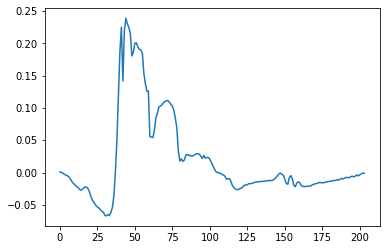

In [38]:
plt.plot(pca.components_[0])

In [180]:
to_transform = train_data[0,:]
data = pca.transform(to_transform.reshape(-1,1))
new_data = np.copy(data)
new_data[:,0] = data[:,0]*10
print(np.mean(new_data-data))
transformed = pca.inverse_transform(new_data)
print(np.mean(transformed - to_transform))

-0.47017622
-0.09686612


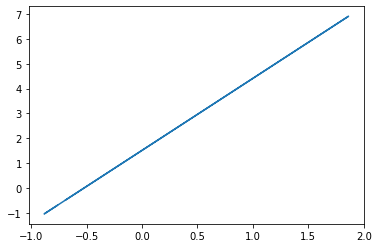

In [39]:
train_gt, test_gt = utils.sample_gt(gt, 0.3,
                                        mode='disjoint')

train_gt, val_gt = utils.sample_gt(train_gt, 0.95, mode='disjoint')

val_dataset = HyperX(img, val_gt, labeled=True, **hyperparams)
val_loader = data.DataLoader(val_dataset,
                             batch_size=10)

train_labeled_gt, train_unlabeled_gt = utils.sample_gt(train_gt, 1/(7 + 1),
                                                        mode='disjoint')

samples_class = np.zeros(n_classes)
for c in np.unique(train_labeled_gt):
    samples_class[c-1] = np.count_nonzero(train_labeled_gt == c)

train_labeled_dataset = HyperX(img, train_labeled_gt, labeled=True, **hyperparams)
train_labeled_loader = data.DataLoader(train_labeled_dataset, batch_size=10,
                                       #pin_memory=True, num_workers=5,
                                       shuffle=True, drop_last=True)

train_unlabeled_dataset = HyperX(img, train_unlabeled_gt, labeled=False, **hyperparams)
train_unlabeled_loader = data.DataLoader(train_unlabeled_dataset,
                                         batch_size=10*7,
                                         #pin_memory=True, num_workers=5,
                                         shuffle=True, drop_last=True)

NameError: name 'gt' is not defined

In [ ]:
samples_labeled = []

for i in range(train_labeled_dataset.__len__()):
    samples_labeled.append(train_labeled_dataset.__getitem__(i)[0])

In [ ]:
samples_labeled[0]

In [ ]:
samples_train = []

for i in range(train_dataset.__len__()):
    samples_train.append(train_dataset.__getitem__(i)[0])

In [ ]:
samples_train[0]

In [9]:
np.max(test_img)

1.1002865

In [16]:
from sklearn.metrics import classification_report

In [18]:
print(classification_report(test_gt.flatten(), test_gt.flatten()))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     64809
           1       1.00      1.00      1.00      1787
           2       1.00      1.00      1.00      3356
           3       1.00      1.00      1.00      1976
           4       1.00      1.00      1.00      1394
           5       1.00      1.00      1.00      2527
           6       1.00      1.00      1.00      3959
           7       1.00      1.00      1.00      3579
           8       1.00      1.00      1.00      9860
           9       1.00      1.00      1.00      5983
          10       1.00      1.00      1.00      2441
          11       1.00      1.00      1.00       968
          12       1.00      1.00      1.00      1903
          13       1.00      1.00      1.00       875
          14       1.00      1.00      1.00       883
          15       1.00      1.00      1.00      5958
          16       1.00      1.00      1.00      1778

    accuracy              

In [19]:
for i in range(0,5):
    print(i)

0
1
2
3
4


In [11]:
x_train, y_train = utils.build_dataset(train_img, train_gt, ignored_labels=ignored_labels)

In [15]:
import sklearn.svm as SVM

In [16]:
clf = SVM.SVC(class_weight='balanced')
clf.fit(x_train, y_train)
prediction = clf.predict(test_img.reshape(-1, n_bands))
prediction = prediction.reshape(test_img.shape[:2])

/home/oscar/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [21]:
run_results = utils.metrics(prediction, test_gt, ignored_labels=ignored_labels, n_classes=n_classes)

mask = np.zeros(test_gt.shape, dtype='bool')
for l in ignored_labels:
    mask[test_gt == l] = True
prediction[mask] = 0

color_prediction = convert_to_color(prediction)
utils.display_predictions(color_prediction, vis, gt=convert_to_color(test_gt), caption="Prediction vs. test ground truth")

utils.show_results(run_results, vis, label_values=label_values)

Confusion matrix :
[[   0 1787    0    0    0    0    0    0    0    0    0    0    0    0
     0    0]
 [   0 3217   43    0    0    0    0    0    2    0    0    0    0    0
    91    3]
 [   0    0    0    0    0   19    0    0    0 1953    0    0    0    0
     0    0]
 [   0    0    0    0    0    2    0    0    0    0    0    0    0    0
     0    0]
 [   0    0    0    0    0 1611    0    0    0  596    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0  491    9 2310    0    5
  1144    0]
 [   0  818    0    0    0    0    0    0    5    1    1    0    0    0
  2740   13]
 [   0    0    0    0    0    2    0    0   20  122   28    0    0   12
    40 9517]
 [   0    0    0    0    0    0    0    0    0 5982    1    0    0    0
     0    0]
 [   0    0    0    0    0    5    0    0    6 1800   53    0    0    4
    25  526]
 [   0    0    0    0    0    0    0    0    0  965    0    0    0    0
     0    0]
 [   0    0    0    0    0    0    0    0    0

In [39]:
unique_labels = np.zeros(len(label_values))
new_idx_sup = []
index = 0
for p,x,y in idx_sup:
    label = train_gt[p,x,y]
    if unique_labels[label] < 10:
        unique_labels[label] += 1
        new_idx_sup.append([p,x,y])
        np.delete(idx_sup, index)
    index += 1

In [42]:
np.asarray(new_idx_sup).shape

(120, 3)

In [52]:
idx_sup

array([[11, 12,  5],
       [10,  5,  5],
       [22, 20,  3],
       ...,
       [ 3,  5,  6],
       [24,  6,  2],
       [25, 18, 11]])

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

In [50]:
new_idx_unsup = np.concatenate((idx_sup, idx_unsup))

In [51]:
new_idx_unsup.shape

(5694, 3)

Connection is already closed.
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 11

[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 111] Connection refused
[Errno 1

In [9]:
data_path = '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Pavia University'
train_img, train_gt, test_img, test_gt, label_values, ignored_labels, rgb_bands, palette = get_patch_data('Pavia', 5, target_folder=data_path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/oscar/Desktop/Exjobb/Data/ieee_supplement/Hyperspectral_Grids/Pavia University/pavia_fold_0/patch_16.npy'

In [54]:
import importlib
import models

In [59]:
models = importlib.reload(models)

In [60]:
model = models.NalepaEtAl(n_bands, n_classes)

optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9,
                          nesterov=True)

In [68]:
i = 0
X = np.zeros((len(idx_sup), n_bands))
Y = np.zeros(len(idx_sup))
for p, x, y in idx_sup:
    X[i, :] = train_img[p,x,y]
    Y[i] = train_gt[p,x,y] - 1
    i += 1

In [75]:
criterion = nn.CrossEntropyLoss()
for e in range(5):
    model.train()
    for idx, (data, target) in enumerate(train_labeled_loader):
        target = target - 1
        output = model(data)
        loss = criterion(output, target)
        print(loss)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        

RuntimeError: Expected 3-dimensional input for 3-dimensional weight 200 1 5, but got 2-dimensional input of size [10, 204] instead

In [64]:
for data, target in enumerate(train_labeled_loader):
    print(data)
    print(target)

0
[tensor([[[[[0.0413, 0.0490, 0.0413, 0.0567, 0.0490],
           [0.0418, 0.0418, 0.0495, 0.0495, 0.0418],
           [0.0487, 0.0409, 0.0409, 0.0409, 0.0487],
           [0.0413, 0.0490, 0.0413, 0.0413, 0.0335],
           [0.0409, 0.0409, 0.0487, 0.0409, 0.0409]],

          [[0.0534, 0.0534, 0.0534, 0.0625, 0.0534],
           [0.0519, 0.0519, 0.0519, 0.0610, 0.0519],
           [0.0622, 0.0532, 0.0532, 0.0532, 0.0622],
           [0.0624, 0.0624, 0.0533, 0.0533, 0.0533],
           [0.0527, 0.0527, 0.0709, 0.0527, 0.0527]],

          [[0.0811, 0.0740, 0.0811, 0.0882, 0.0740],
           [0.0793, 0.0722, 0.0793, 0.0864, 0.0793],
           [0.0868, 0.0726, 0.0726, 0.0726, 0.0798],
           [0.0800, 0.0800, 0.0728, 0.0800, 0.0800],
           [0.0800, 0.0728, 0.0800, 0.0800, 0.0728]],

          ...,

          [[0.0016, 0.0014, 0.0010, 0.0023, 0.0016],
           [0.0018, 0.0014, 0.0016, 0.0014, 0.0012],
           [0.0016, 0.0018, 0.0025, 0.0014, 0.0021],
           [0.0016, 0

[tensor([[[[[0.0489, 0.0412, 0.0489, 0.0412, 0.0489],
           [0.0489, 0.0412, 0.0489, 0.0412, 0.0489],
           [0.0344, 0.0421, 0.0499, 0.0421, 0.0499],
           [0.0493, 0.0416, 0.0416, 0.0416, 0.0493],
           [0.0412, 0.0489, 0.0412, 0.0412, 0.0489]],

          [[0.0537, 0.0537, 0.0537, 0.0537, 0.0628],
           [0.0537, 0.0537, 0.0537, 0.0537, 0.0628],
           [0.0625, 0.0625, 0.0625, 0.0625, 0.0534],
           [0.0540, 0.0630, 0.0540, 0.0449, 0.0630],
           [0.0530, 0.0439, 0.0530, 0.0439, 0.0621]],

          [[0.0805, 0.0805, 0.0876, 0.0805, 0.0876],
           [0.0805, 0.0805, 0.0876, 0.0805, 0.0876],
           [0.0815, 0.0815, 0.0887, 0.0887, 0.0957],
           [0.0811, 0.0882, 0.0811, 0.0740, 0.0811],
           [0.0736, 0.0806, 0.0736, 0.0736, 0.0877]],

          ...,

          [[0.0077, 0.0073, 0.0077, 0.0075, 0.0075],
           [0.0077, 0.0073, 0.0077, 0.0075, 0.0075],
           [0.0076, 0.0080, 0.0065, 0.0069, 0.0072],
           [0.0066, 0.0

[tensor([[[[[0.0332, 0.0332, 0.0409, 0.0332, 0.0332],
           [0.0332, 0.0332, 0.0409, 0.0332, 0.0332],
           [0.0339, 0.0339, 0.0416, 0.0416, 0.0416],
           [0.0260, 0.0339, 0.0416, 0.0339, 0.0416],
           [0.0417, 0.0417, 0.0340, 0.0417, 0.0417]],

          [[0.0533, 0.0442, 0.0352, 0.0352, 0.0442],
           [0.0533, 0.0442, 0.0352, 0.0352, 0.0442],
           [0.0434, 0.0434, 0.0524, 0.0434, 0.0434],
           [0.0449, 0.0449, 0.0449, 0.0449, 0.0540],
           [0.0421, 0.0421, 0.0421, 0.0511, 0.0421]],

          [[0.0654, 0.0583, 0.0583, 0.0654, 0.0654],
           [0.0654, 0.0583, 0.0583, 0.0654, 0.0654],
           [0.0594, 0.0664, 0.0594, 0.0594, 0.0664],
           [0.0590, 0.0590, 0.0731, 0.0661, 0.0590],
           [0.0654, 0.0654, 0.0654, 0.0654, 0.0583]],

          ...,

          [[0.0012, 0.0016, 0.0016, 0.0012, 0.0009],
           [0.0012, 0.0016, 0.0016, 0.0012, 0.0009],
           [0.0009, 0.0018, 0.0018, 0.0016, 0.0018],
           [0.0014, 0.0

[tensor([[[[[0.0000, 0.0336, 0.0414, 0.0414, 0.0492],
           [0.0000, 0.0407, 0.0252, 0.0407, 0.0407],
           [0.0000, 0.0407, 0.0252, 0.0407, 0.0407],
           [0.0000, 0.0406, 0.0406, 0.0406, 0.0329],
           [0.0000, 0.0406, 0.0406, 0.0406, 0.0329]],

          [[0.0000, 0.0446, 0.0537, 0.0446, 0.0446],
           [0.0000, 0.0536, 0.0536, 0.0536, 0.0536],
           [0.0000, 0.0536, 0.0536, 0.0536, 0.0536],
           [0.0000, 0.0434, 0.0434, 0.0434, 0.0434],
           [0.0000, 0.0434, 0.0434, 0.0434, 0.0434]],

          [[0.0000, 0.0590, 0.0731, 0.0803, 0.0803],
           [0.0000, 0.0653, 0.0653, 0.0653, 0.0795],
           [0.0000, 0.0653, 0.0653, 0.0653, 0.0795],
           [0.0000, 0.0658, 0.0658, 0.0658, 0.0586],
           [0.0000, 0.0658, 0.0658, 0.0658, 0.0586]],

          ...,

          [[0.0000, 0.0084, 0.0084, 0.0086, 0.0077],
           [0.0000, 0.0044, 0.0051, 0.0068, 0.0084],
           [0.0000, 0.0044, 0.0051, 0.0068, 0.0084],
           [0.0000, 0.0

[tensor([[[[[0.0000, 0.0000, 0.0410, 0.0333, 0.0333],
           [0.0000, 0.0000, 0.0410, 0.0333, 0.0333],
           [0.0000, 0.0000, 0.0410, 0.0333, 0.0333],
           [0.0000, 0.0000, 0.0326, 0.0326, 0.0326],
           [0.0000, 0.0000, 0.0326, 0.0326, 0.0326]],

          [[0.0000, 0.0000, 0.0527, 0.0436, 0.0527],
           [0.0000, 0.0000, 0.0527, 0.0436, 0.0527],
           [0.0000, 0.0000, 0.0527, 0.0436, 0.0527],
           [0.0000, 0.0000, 0.0454, 0.0545, 0.0545],
           [0.0000, 0.0000, 0.0454, 0.0545, 0.0545]],

          [[0.0000, 0.0000, 0.0736, 0.0664, 0.0594],
           [0.0000, 0.0000, 0.0736, 0.0664, 0.0594],
           [0.0000, 0.0000, 0.0736, 0.0664, 0.0594],
           [0.0000, 0.0000, 0.0680, 0.0752, 0.0680],
           [0.0000, 0.0000, 0.0680, 0.0752, 0.0680]],

          ...,

          [[0.0000, 0.0000, 0.0051, 0.0058, 0.0051],
           [0.0000, 0.0000, 0.0051, 0.0058, 0.0051],
           [0.0000, 0.0000, 0.0051, 0.0058, 0.0051],
           [0.0000, 0.0

[tensor([[[[[0.0326, 0.0326, 0.0326, 0.0404, 0.0404],
           [0.0405, 0.0328, 0.0250, 0.0328, 0.0405],
           [0.0332, 0.0487, 0.0332, 0.0409, 0.0409],
           [0.0324, 0.0403, 0.0324, 0.0403, 0.0480],
           [0.0324, 0.0403, 0.0324, 0.0403, 0.0480]],

          [[0.0436, 0.0527, 0.0527, 0.0527, 0.0436],
           [0.0343, 0.0434, 0.0434, 0.0434, 0.0434],
           [0.0432, 0.0523, 0.0523, 0.0432, 0.0432],
           [0.0526, 0.0526, 0.0435, 0.0526, 0.0526],
           [0.0526, 0.0526, 0.0435, 0.0526, 0.0526]],

          [[0.0658, 0.0658, 0.0658, 0.0728, 0.0658],
           [0.0658, 0.0728, 0.0658, 0.0728, 0.0728],
           [0.0663, 0.0805, 0.0805, 0.0663, 0.0735],
           [0.0725, 0.0725, 0.0725, 0.0725, 0.0654],
           [0.0725, 0.0725, 0.0725, 0.0725, 0.0654]],

          ...,

          [[0.0040, 0.0038, 0.0053, 0.0051, 0.0060],
           [0.0038, 0.0042, 0.0047, 0.0044, 0.0055],
           [0.0046, 0.0043, 0.0041, 0.0043, 0.0054],
           [0.0038, 0.0

[tensor([[[[[0.0493, 0.0493, 0.0416, 0.0416, 0.0493],
           [0.0420, 0.0498, 0.0498, 0.0420, 0.0498],
           [0.0489, 0.0412, 0.0489, 0.0489, 0.0489],
           [0.0498, 0.0420, 0.0498, 0.0420, 0.0498],
           [0.0498, 0.0420, 0.0498, 0.0420, 0.0498]],

          [[0.0642, 0.0642, 0.0642, 0.0732, 0.0642],
           [0.0528, 0.0620, 0.0620, 0.0528, 0.0620],
           [0.0523, 0.0523, 0.0523, 0.0704, 0.0523],
           [0.0550, 0.0550, 0.0640, 0.0550, 0.0640],
           [0.0550, 0.0550, 0.0640, 0.0550, 0.0640]],

          [[0.0868, 0.0868, 0.0868, 0.0868, 0.0868],
           [0.0809, 0.0881, 0.0809, 0.0952, 0.0881],
           [0.0873, 0.0873, 0.0873, 0.0803, 0.0945],
           [0.0867, 0.0796, 0.0796, 0.0867, 0.0867],
           [0.0867, 0.0796, 0.0796, 0.0867, 0.0867]],

          ...,

          [[0.0086, 0.0086, 0.0088, 0.0084, 0.0084],
           [0.0084, 0.0092, 0.0086, 0.0090, 0.0090],
           [0.0090, 0.0092, 0.0086, 0.0081, 0.0092],
           [0.0082, 0.0

60
[tensor([[[[[0.0330, 0.0330, 0.0330, 0.0000, 0.0000],
           [0.0335, 0.0335, 0.0335, 0.0000, 0.0000],
           [0.0339, 0.0339, 0.0339, 0.0000, 0.0000],
           [0.0329, 0.0329, 0.0329, 0.0000, 0.0000],
           [0.0329, 0.0329, 0.0329, 0.0000, 0.0000]],

          [[0.0437, 0.0437, 0.0528, 0.0000, 0.0000],
           [0.0340, 0.0431, 0.0340, 0.0000, 0.0000],
           [0.0340, 0.0431, 0.0250, 0.0000, 0.0000],
           [0.0430, 0.0520, 0.0339, 0.0000, 0.0000],
           [0.0430, 0.0520, 0.0339, 0.0000, 0.0000]],

          [[0.0591, 0.0591, 0.0591, 0.0000, 0.0000],
           [0.0591, 0.0591, 0.0662, 0.0000, 0.0000],
           [0.0596, 0.0666, 0.0596, 0.0000, 0.0000],
           [0.0600, 0.0600, 0.0600, 0.0000, 0.0000],
           [0.0600, 0.0600, 0.0600, 0.0000, 0.0000]],

          ...,

          [[0.0044, 0.0023, 0.0012, 0.0000, 0.0000],
           [0.0031, 0.0016, 0.0014, 0.0000, 0.0000],
           [0.0016, 0.0009, 0.0014, 0.0000, 0.0000],
           [0.0013, 

[tensor([[[[[0.0499, 0.0499, 0.0421, 0.0576, 0.0499],
           [0.0414, 0.0492, 0.0414, 0.0414, 0.0414],
           [0.0410, 0.0410, 0.0410, 0.0333, 0.0488],
           [0.0416, 0.0339, 0.0339, 0.0416, 0.0339],
           [0.0416, 0.0416, 0.0416, 0.0339, 0.0493]],

          [[0.0634, 0.0634, 0.0543, 0.0543, 0.0543],
           [0.0625, 0.0625, 0.0444, 0.0534, 0.0534],
           [0.0519, 0.0428, 0.0519, 0.0610, 0.0610],
           [0.0445, 0.0536, 0.0536, 0.0536, 0.0354],
           [0.0533, 0.0533, 0.0442, 0.0442, 0.0442]],

          [[0.0818, 0.0818, 0.0890, 0.0890, 0.0890],
           [0.0813, 0.0742, 0.0742, 0.0813, 0.0742],
           [0.0731, 0.0731, 0.0731, 0.0731, 0.0803],
           [0.0596, 0.0666, 0.0666, 0.0738, 0.0666],
           [0.0662, 0.0662, 0.0734, 0.0734, 0.0662]],

          ...,

          [[0.0031, 0.0034, 0.0044, 0.0040, 0.0047],
           [0.0027, 0.0038, 0.0038, 0.0034, 0.0040],
           [0.0029, 0.0034, 0.0031, 0.0040, 0.0029],
           [0.0027, 0.0

[tensor([[[[[0.0419, 0.0497, 0.0419, 0.0419, 0.0497],
           [0.0418, 0.0418, 0.0418, 0.0418, 0.0573],
           [0.0484, 0.0407, 0.0407, 0.0484, 0.0407],
           [0.0484, 0.0407, 0.0407, 0.0484, 0.0407],
           [0.0421, 0.0421, 0.0344, 0.0421, 0.0421]],

          [[0.0534, 0.0534, 0.0625, 0.0534, 0.0444],
           [0.0533, 0.0624, 0.0533, 0.0533, 0.0533],
           [0.0615, 0.0434, 0.0524, 0.0524, 0.0434],
           [0.0615, 0.0434, 0.0524, 0.0524, 0.0434],
           [0.0616, 0.0526, 0.0616, 0.0526, 0.0616]],

          [[0.0745, 0.0674, 0.0745, 0.0745, 0.0816],
           [0.0726, 0.0726, 0.0798, 0.0655, 0.0798],
           [0.0799, 0.0727, 0.0869, 0.0799, 0.0799],
           [0.0799, 0.0727, 0.0869, 0.0799, 0.0799],
           [0.0796, 0.0725, 0.0725, 0.0725, 0.0725]],

          ...,

          [[0.0016, 0.0014, 0.0012, 0.0004, 0.0016],
           [0.0021, 0.0014, 0.0014, 0.0012, 0.0016],
           [0.0015, 0.0015, 0.0015, 0.0011, 0.0020],
           [0.0015, 0.0

[tensor([[[[[0.0484, 0.0484, 0.0407, 0.0407, 0.0484],
           [0.0344, 0.0421, 0.0421, 0.0344, 0.0421],
           [0.0501, 0.0501, 0.0346, 0.0346, 0.0501],
           [0.0425, 0.0502, 0.0425, 0.0425, 0.0502],
           [0.0425, 0.0502, 0.0425, 0.0425, 0.0502]],

          [[0.0615, 0.0615, 0.0434, 0.0524, 0.0524],
           [0.0526, 0.0616, 0.0526, 0.0616, 0.0526],
           [0.0527, 0.0618, 0.0527, 0.0527, 0.0527],
           [0.0533, 0.0624, 0.0442, 0.0624, 0.0533],
           [0.0533, 0.0624, 0.0442, 0.0624, 0.0533]],

          [[0.0869, 0.0799, 0.0727, 0.0869, 0.0799],
           [0.0654, 0.0796, 0.0725, 0.0725, 0.0725],
           [0.0882, 0.0740, 0.0811, 0.0811, 0.0740],
           [0.0731, 0.0803, 0.0661, 0.0731, 0.0731],
           [0.0731, 0.0803, 0.0661, 0.0731, 0.0731]],

          ...,

          [[0.0020, 0.0015, 0.0015, 0.0015, 0.0011],
           [0.0018, 0.0004, 0.0012, 0.0018, 0.0012],
           [0.0015, 0.0017, 0.0017, 0.0005, 0.0015],
           [0.0016, 0.0

[tensor([[[[[0.0412, 0.0334, 0.0412, 0.0412, 0.0412],
           [0.0412, 0.0334, 0.0412, 0.0412, 0.0412],
           [0.0481, 0.0404, 0.0481, 0.0404, 0.0326],
           [0.0485, 0.0485, 0.0408, 0.0485, 0.0485],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0533, 0.0533, 0.0533, 0.0624, 0.0533],
           [0.0533, 0.0533, 0.0533, 0.0624, 0.0533],
           [0.0621, 0.0439, 0.0439, 0.0621, 0.0530],
           [0.0527, 0.0618, 0.0527, 0.0436, 0.0527],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0798, 0.0655, 0.0726, 0.0798, 0.0798],
           [0.0798, 0.0655, 0.0726, 0.0798, 0.0798],
           [0.0805, 0.0735, 0.0805, 0.0735, 0.0805],
           [0.0728, 0.0870, 0.0800, 0.0870, 0.0800],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          ...,

          [[0.0010, 0.0022, 0.0020, 0.0015, 0.0017],
           [0.0010, 0.0022, 0.0020, 0.0015, 0.0017],
           [0.0013, 0.0011, 0.0020, 0.0017, 0.0015],
           [0.0014, 0.0

[tensor([[[[[0.0409, 0.0487, 0.0332, 0.0409, 0.0421],
           [0.0409, 0.0487, 0.0332, 0.0409, 0.0487],
           [0.0414, 0.0492, 0.0414, 0.0414, 0.0414],
           [0.0413, 0.0413, 0.0413, 0.0335, 0.0413],
           [0.0388, 0.0388, 0.0388, 0.0388, 0.0311]],

          [[0.0625, 0.0534, 0.0534, 0.0534, 0.0620],
           [0.0625, 0.0534, 0.0534, 0.0534, 0.0534],
           [0.0437, 0.0620, 0.0528, 0.0528, 0.0528],
           [0.0532, 0.0532, 0.0532, 0.0532, 0.0441],
           [0.0425, 0.0425, 0.0515, 0.0515, 0.0334]],

          [[0.0796, 0.0725, 0.0725, 0.0654, 0.0805],
           [0.0796, 0.0725, 0.0725, 0.0654, 0.0725],
           [0.0730, 0.0730, 0.0730, 0.0730, 0.0730],
           [0.0729, 0.0729, 0.0729, 0.0729, 0.0659],
           [0.0723, 0.0652, 0.0723, 0.0652, 0.0652]],

          ...,

          [[0.0029, 0.0029, 0.0031, 0.0021, 0.0025],
           [0.0029, 0.0029, 0.0031, 0.0021, 0.0023],
           [0.0026, 0.0035, 0.0033, 0.0030, 0.0028],
           [0.0029, 0.0

[tensor([[[[[0.0328, 0.0405, 0.0328, 0.0250, 0.0328],
           [0.0244, 0.0244, 0.0321, 0.0321, 0.0244],
           [0.0263, 0.0341, 0.0263, 0.0341, 0.0341],
           [0.0349, 0.0349, 0.0349, 0.0349, 0.0349],
           [0.0349, 0.0349, 0.0349, 0.0349, 0.0349]],

          [[0.0434, 0.0434, 0.0343, 0.0343, 0.0434],
           [0.0417, 0.0417, 0.0417, 0.0508, 0.0326],
           [0.0434, 0.0343, 0.0434, 0.0434, 0.0434],
           [0.0344, 0.0435, 0.0344, 0.0526, 0.0435],
           [0.0344, 0.0435, 0.0344, 0.0526, 0.0435]],

          [[0.0581, 0.0581, 0.0652, 0.0581, 0.0652],
           [0.0508, 0.0578, 0.0578, 0.0508, 0.0650],
           [0.0511, 0.0582, 0.0653, 0.0653, 0.0653],
           [0.0663, 0.0592, 0.0592, 0.0592, 0.0592],
           [0.0663, 0.0592, 0.0592, 0.0592, 0.0592]],

          ...,

          [[0.0025, 0.0029, 0.0027, 0.0023, 0.0027],
           [0.0029, 0.0025, 0.0025, 0.0029, 0.0027],
           [0.0037, 0.0030, 0.0028, 0.0026, 0.0028],
           [0.0027, 0.0

[tensor([[[[[0.0418, 0.0418, 0.0495, 0.0418, 0.0418],
           [0.0412, 0.0412, 0.0412, 0.0412, 0.0412],
           [0.0412, 0.0412, 0.0412, 0.0412, 0.0412],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0537, 0.0537, 0.0537, 0.0446, 0.0446],
           [0.0534, 0.0534, 0.0534, 0.0444, 0.0534],
           [0.0534, 0.0534, 0.0534, 0.0444, 0.0534],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0731, 0.0803, 0.0873, 0.0661, 0.0661],
           [0.0740, 0.0740, 0.0668, 0.0668, 0.0740],
           [0.0740, 0.0740, 0.0668, 0.0668, 0.0740],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          ...,

          [[0.0014, 0.0016, 0.0016, 0.0016, 0.0012],
           [0.0010, 0.0012, 0.0018, 0.0016, 0.0014],
           [0.0010, 0.0012, 0.0018, 0.0016, 0.0014],
           [0.0000, 0.0

[tensor([[[[[0.0409, 0.0409, 0.0487, 0.0332, 0.0409],
           [0.0492, 0.0414, 0.0492, 0.0414, 0.0414],
           [0.0413, 0.0413, 0.0413, 0.0413, 0.0335],
           [0.0388, 0.0388, 0.0388, 0.0388, 0.0388],
           [0.0416, 0.0416, 0.0416, 0.0416, 0.0416]],

          [[0.0534, 0.0625, 0.0534, 0.0534, 0.0534],
           [0.0528, 0.0437, 0.0620, 0.0528, 0.0528],
           [0.0532, 0.0532, 0.0532, 0.0532, 0.0532],
           [0.0515, 0.0425, 0.0425, 0.0515, 0.0515],
           [0.0533, 0.0442, 0.0442, 0.0533, 0.0442]],

          [[0.0725, 0.0796, 0.0725, 0.0725, 0.0654],
           [0.0730, 0.0730, 0.0730, 0.0730, 0.0730],
           [0.0729, 0.0729, 0.0729, 0.0729, 0.0729],
           [0.0652, 0.0723, 0.0652, 0.0723, 0.0652],
           [0.0659, 0.0587, 0.0659, 0.0659, 0.0659]],

          ...,

          [[0.0042, 0.0029, 0.0029, 0.0031, 0.0021],
           [0.0035, 0.0026, 0.0035, 0.0033, 0.0030],
           [0.0034, 0.0029, 0.0027, 0.0034, 0.0031],
           [0.0033, 0.0

[tensor([[[[[0.0000, 0.0000, 0.0407, 0.0330, 0.0330],
           [0.0000, 0.0000, 0.0407, 0.0252, 0.0330],
           [0.0000, 0.0000, 0.0336, 0.0336, 0.0336],
           [0.0000, 0.0000, 0.0336, 0.0336, 0.0336],
           [0.0000, 0.0000, 0.0326, 0.0404, 0.0326]],

          [[0.0000, 0.0000, 0.0347, 0.0437, 0.0528],
           [0.0000, 0.0000, 0.0442, 0.0442, 0.0442],
           [0.0000, 0.0000, 0.0439, 0.0530, 0.0348],
           [0.0000, 0.0000, 0.0439, 0.0439, 0.0348],
           [0.0000, 0.0000, 0.0437, 0.0437, 0.0437]],

          [[0.0000, 0.0000, 0.0512, 0.0583, 0.0654],
           [0.0000, 0.0000, 0.0654, 0.0654, 0.0583],
           [0.0000, 0.0000, 0.0660, 0.0660, 0.0589],
           [0.0000, 0.0000, 0.0655, 0.0655, 0.0584],
           [0.0000, 0.0000, 0.0663, 0.0663, 0.0592]],

          ...,

          [[0.0000, 0.0000, 0.0021, 0.0025, 0.0031],
           [0.0000, 0.0000, 0.0021, 0.0027, 0.0029],
           [0.0000, 0.0000, 0.0033, 0.0028, 0.0028],
           [0.0000, 0.0

[tensor([[[[[0.0328, 0.0405, 0.0405, 0.0405, 0.0405],
           [0.0412, 0.0334, 0.0412, 0.0257, 0.0412],
           [0.0243, 0.0397, 0.0320, 0.0397, 0.0320],
           [0.0243, 0.0397, 0.0320, 0.0397, 0.0320],
           [0.0417, 0.0417, 0.0340, 0.0417, 0.0417]],

          [[0.0532, 0.0441, 0.0441, 0.0532, 0.0441],
           [0.0426, 0.0518, 0.0518, 0.0426, 0.0518],
           [0.0347, 0.0437, 0.0437, 0.0437, 0.0528],
           [0.0347, 0.0437, 0.0437, 0.0437, 0.0528],
           [0.0421, 0.0511, 0.0421, 0.0421, 0.0421]],

          [[0.0589, 0.0589, 0.0660, 0.0589, 0.0589],
           [0.0582, 0.0653, 0.0582, 0.0582, 0.0724],
           [0.0579, 0.0579, 0.0579, 0.0722, 0.0579],
           [0.0579, 0.0579, 0.0579, 0.0722, 0.0579],
           [0.0583, 0.0654, 0.0654, 0.0654, 0.0654]],

          ...,

          [[0.0016, 0.0014, 0.0009, 0.0014, 0.0021],
           [0.0016, 0.0014, 0.0012, 0.0021, 0.0014],
           [0.0016, 0.0010, 0.0014, 0.0014, 0.0014],
           [0.0016, 0.0

[tensor([[[[[0.0405, 0.0482, 0.0405, 0.0482, 0.0328],
           [0.0405, 0.0482, 0.0483, 0.0483, 0.0406],
           [0.0329, 0.0406, 0.0483, 0.0483, 0.0406],
           [0.0418, 0.0495, 0.0495, 0.0418, 0.0341],
           [0.0406, 0.0406, 0.0483, 0.0483, 0.0406]],

          [[0.0620, 0.0528, 0.0711, 0.0437, 0.0437],
           [0.0620, 0.0528, 0.0706, 0.0524, 0.0524],
           [0.0524, 0.0524, 0.0706, 0.0524, 0.0524],
           [0.0528, 0.0620, 0.0620, 0.0620, 0.0437],
           [0.0607, 0.0515, 0.0607, 0.0607, 0.0425]],

          [[0.0808, 0.0808, 0.0880, 0.0808, 0.0738],
           [0.0808, 0.0808, 0.0804, 0.0804, 0.0804],
           [0.0804, 0.0804, 0.0804, 0.0804, 0.0804],
           [0.0802, 0.0802, 0.0802, 0.0802, 0.0802],
           [0.0871, 0.0801, 0.0801, 0.0801, 0.0729]],

          ...,

          [[0.0062, 0.0053, 0.0058, 0.0055, 0.0055],
           [0.0062, 0.0053, 0.0058, 0.0058, 0.0064],
           [0.0055, 0.0064, 0.0058, 0.0058, 0.0064],
           [0.0058, 0.0

[tensor([[[[[0.0000, 0.0344, 0.0344, 0.0421, 0.0421],
           [0.0000, 0.0326, 0.0326, 0.0404, 0.0404],
           [0.0000, 0.0484, 0.0330, 0.0407, 0.0330],
           [0.0000, 0.0334, 0.0334, 0.0334, 0.0334],
           [0.0000, 0.0334, 0.0334, 0.0334, 0.0334]],

          [[0.0000, 0.0437, 0.0528, 0.0437, 0.0437],
           [0.0000, 0.0545, 0.0362, 0.0454, 0.0454],
           [0.0000, 0.0437, 0.0437, 0.0437, 0.0437],
           [0.0000, 0.0434, 0.0343, 0.0434, 0.0434],
           [0.0000, 0.0434, 0.0343, 0.0434, 0.0434]],

          [[0.0000, 0.0592, 0.0592, 0.0592, 0.0663],
           [0.0000, 0.0730, 0.0660, 0.0660, 0.0660],
           [0.0000, 0.0574, 0.0574, 0.0574, 0.0646],
           [0.0000, 0.0584, 0.0655, 0.0655, 0.0726],
           [0.0000, 0.0584, 0.0655, 0.0655, 0.0726]],

          ...,

          [[0.0000, 0.0031, 0.0036, 0.0031, 0.0034],
           [0.0000, 0.0027, 0.0027, 0.0036, 0.0029],
           [0.0000, 0.0021, 0.0034, 0.0023, 0.0029],
           [0.0000, 0.0

[tensor([[[[[0.0339, 0.0416, 0.0416, 0.0416, 0.0416],
           [0.0339, 0.0416, 0.0416, 0.0416, 0.0339],
           [0.0333, 0.0488, 0.0410, 0.0410, 0.0410],
           [0.0414, 0.0492, 0.0336, 0.0414, 0.0492],
           [0.0421, 0.0421, 0.0421, 0.0499, 0.0499]],

          [[0.0352, 0.0533, 0.0533, 0.0533, 0.0533],
           [0.0445, 0.0445, 0.0445, 0.0445, 0.0536],
           [0.0428, 0.0519, 0.0519, 0.0519, 0.0428],
           [0.0534, 0.0534, 0.0716, 0.0625, 0.0625],
           [0.0543, 0.0634, 0.0543, 0.0634, 0.0634]],

          [[0.0591, 0.0734, 0.0662, 0.0662, 0.0662],
           [0.0666, 0.0666, 0.0738, 0.0596, 0.0666],
           [0.0590, 0.0731, 0.0661, 0.0731, 0.0731],
           [0.0742, 0.0671, 0.0671, 0.0813, 0.0742],
           [0.0748, 0.0818, 0.0748, 0.0818, 0.0818]],

          ...,

          [[0.0027, 0.0031, 0.0029, 0.0031, 0.0023],
           [0.0034, 0.0027, 0.0027, 0.0027, 0.0029],
           [0.0031, 0.0025, 0.0031, 0.0029, 0.0034],
           [0.0027, 0.0

[tensor([[[[[0.0000, 0.0344, 0.0421, 0.0267, 0.0267],
           [0.0000, 0.0409, 0.0255, 0.0267, 0.0267],
           [0.0000, 0.0409, 0.0255, 0.0332, 0.0409],
           [0.0000, 0.0336, 0.0336, 0.0336, 0.0336],
           [0.0000, 0.0413, 0.0413, 0.0413, 0.0413]],

          [[0.0000, 0.0347, 0.0437, 0.0528, 0.0528],
           [0.0000, 0.0444, 0.0353, 0.0528, 0.0528],
           [0.0000, 0.0444, 0.0353, 0.0444, 0.0444],
           [0.0000, 0.0528, 0.0347, 0.0528, 0.0347],
           [0.0000, 0.0532, 0.0441, 0.0532, 0.0441]],

          [[0.0000, 0.0663, 0.0735, 0.0735, 0.0735],
           [0.0000, 0.0654, 0.0725, 0.0735, 0.0735],
           [0.0000, 0.0654, 0.0725, 0.0725, 0.0725],
           [0.0000, 0.0802, 0.0589, 0.0660, 0.0660],
           [0.0000, 0.0729, 0.0729, 0.0729, 0.0801]],

          ...,

          [[0.0000, 0.0049, 0.0042, 0.0044, 0.0042],
           [0.0000, 0.0042, 0.0042, 0.0044, 0.0042],
           [0.0000, 0.0042, 0.0042, 0.0051, 0.0040],
           [0.0000, 0.0

200
[tensor([[[[[0.0495, 0.0495, 0.0495, 0.0495, 0.0418],
           [0.0567, 0.0567, 0.0490, 0.0413, 0.0490],
           [0.0483, 0.0483, 0.0483, 0.0483, 0.0561],
           [0.0483, 0.0483, 0.0483, 0.0483, 0.0561],
           [0.0488, 0.0565, 0.0488, 0.0565, 0.0410]],

          [[0.0628, 0.0718, 0.0718, 0.0628, 0.0628],
           [0.0630, 0.0722, 0.0722, 0.0630, 0.0722],
           [0.0725, 0.0725, 0.0634, 0.0634, 0.0634],
           [0.0725, 0.0725, 0.0634, 0.0634, 0.0634],
           [0.0709, 0.0618, 0.0709, 0.0709, 0.0618]],

          [[0.0882, 0.0811, 0.0953, 0.0953, 0.0882],
           [0.0947, 0.0947, 0.1018, 0.0876, 0.0876],
           [0.1024, 0.0953, 0.0953, 0.0882, 0.0953],
           [0.1024, 0.0953, 0.0953, 0.0882, 0.0953],
           [0.0942, 0.1012, 0.1012, 0.0870, 0.0870]],

          ...,

          [[0.0042, 0.0044, 0.0040, 0.0042, 0.0044],
           [0.0047, 0.0040, 0.0047, 0.0047, 0.0042],
           [0.0044, 0.0051, 0.0042, 0.0044, 0.0044],
           [0.0044,

[tensor([[[[[0.0430, 0.0430, 0.0508, 0.0000, 0.0000],
           [0.0487, 0.0409, 0.0409, 0.0000, 0.0000],
           [0.0511, 0.0511, 0.0434, 0.0000, 0.0000],
           [0.0417, 0.0417, 0.0417, 0.0000, 0.0000],
           [0.0423, 0.0500, 0.0500, 0.0000, 0.0000]],

          [[0.0527, 0.0527, 0.0527, 0.0000, 0.0000],
           [0.0530, 0.0621, 0.0530, 0.0000, 0.0000],
           [0.0543, 0.0634, 0.0543, 0.0000, 0.0000],
           [0.0454, 0.0545, 0.0635, 0.0000, 0.0000],
           [0.0456, 0.0547, 0.0547, 0.0000, 0.0000]],

          [[0.0799, 0.0799, 0.0727, 0.0000, 0.0000],
           [0.0798, 0.0726, 0.0655, 0.0000, 0.0000],
           [0.0803, 0.0803, 0.0731, 0.0000, 0.0000],
           [0.0747, 0.0817, 0.0817, 0.0000, 0.0000],
           [0.0748, 0.0818, 0.0818, 0.0000, 0.0000]],

          ...,

          [[0.0010, 0.0018, 0.0009, 0.0000, 0.0000],
           [0.0021, 0.0016, 0.0012, 0.0000, 0.0000],
           [0.0018, 0.0014, 0.0012, 0.0000, 0.0000],
           [0.0012, 0.0

[tensor([[[[[0.0000, 0.0000, 0.0407, 0.0407, 0.0407],
           [0.0000, 0.0000, 0.0340, 0.0417, 0.0340],
           [0.0000, 0.0000, 0.0421, 0.0421, 0.0499],
           [0.0000, 0.0000, 0.0497, 0.0342, 0.0497],
           [0.0000, 0.0000, 0.0500, 0.0500, 0.0423]],

          [[0.0000, 0.0000, 0.0530, 0.0621, 0.0530],
           [0.0000, 0.0000, 0.0536, 0.0626, 0.0536],
           [0.0000, 0.0000, 0.0546, 0.0546, 0.0546],
           [0.0000, 0.0000, 0.0621, 0.0530, 0.0621],
           [0.0000, 0.0000, 0.0547, 0.0547, 0.0456]],

          [[0.0000, 0.0000, 0.0806, 0.0736, 0.0806],
           [0.0000, 0.0000, 0.0800, 0.0800, 0.0800],
           [0.0000, 0.0000, 0.0739, 0.0809, 0.0809],
           [0.0000, 0.0000, 0.0809, 0.0739, 0.0809],
           [0.0000, 0.0000, 0.0818, 0.0818, 0.0748]],

          ...,

          [[0.0000, 0.0000, 0.0008, 0.0020, 0.0017],
           [0.0000, 0.0000, 0.0012, 0.0016, 0.0010],
           [0.0000, 0.0000, 0.0012, 0.0014, 0.0018],
           [0.0000, 0.0

[tensor([[[[[0.0336, 0.0336, 0.0336, 0.0336, 0.0492],
           [0.0326, 0.0326, 0.0404, 0.0326, 0.0326],
           [0.0326, 0.0326, 0.0396, 0.0241, 0.0396],
           [0.0241, 0.0396, 0.0396, 0.0241, 0.0396],
           [0.0255, 0.0332, 0.0255, 0.0409, 0.0409]],

          [[0.0439, 0.0439, 0.0348, 0.0439, 0.0530],
           [0.0437, 0.0437, 0.0528, 0.0437, 0.0347],
           [0.0437, 0.0437, 0.0537, 0.0446, 0.0356],
           [0.0446, 0.0356, 0.0537, 0.0446, 0.0356],
           [0.0347, 0.0347, 0.0347, 0.0437, 0.0437]],

          [[0.0655, 0.0655, 0.0655, 0.0655, 0.0584],
           [0.0663, 0.0592, 0.0663, 0.0592, 0.0592],
           [0.0663, 0.0592, 0.0586, 0.0586, 0.0586],
           [0.0586, 0.0586, 0.0586, 0.0586, 0.0586],
           [0.0646, 0.0574, 0.0646, 0.0646, 0.0574]],

          ...,

          [[0.0026, 0.0022, 0.0026, 0.0024, 0.0026],
           [0.0023, 0.0023, 0.0027, 0.0023, 0.0029],
           [0.0023, 0.0023, 0.0028, 0.0030, 0.0028],
           [0.0024, 0.0

[tensor([[[[[0.0324, 0.0324, 0.0324, 0.0324, 0.0247],
           [0.0322, 0.0322, 0.0322, 0.0322, 0.0322],
           [0.0320, 0.0397, 0.0397, 0.0320, 0.0320],
           [0.0394, 0.0394, 0.0317, 0.0317, 0.0317],
           [0.0408, 0.0331, 0.0331, 0.0331, 0.0408]],

          [[0.0344, 0.0435, 0.0435, 0.0435, 0.0344],
           [0.0339, 0.0430, 0.0430, 0.0339, 0.0520],
           [0.0426, 0.0426, 0.0426, 0.0426, 0.0335],
           [0.0347, 0.0437, 0.0528, 0.0437, 0.0437],
           [0.0527, 0.0527, 0.0436, 0.0436, 0.0436]],

          [[0.0660, 0.0589, 0.0589, 0.0518, 0.0518],
           [0.0583, 0.0583, 0.0583, 0.0654, 0.0583],
           [0.0643, 0.0572, 0.0643, 0.0643, 0.0572],
           [0.0597, 0.0597, 0.0667, 0.0597, 0.0597],
           [0.0581, 0.0652, 0.0581, 0.0581, 0.0652]],

          ...,

          [[0.0025, 0.0027, 0.0034, 0.0023, 0.0021],
           [0.0023, 0.0023, 0.0023, 0.0021, 0.0021],
           [0.0024, 0.0020, 0.0020, 0.0020, 0.0035],
           [0.0021, 0.0

[tensor([[[[[0.0328, 0.0405, 0.0328, 0.0328, 0.0250],
           [0.0412, 0.0412, 0.0334, 0.0412, 0.0334],
           [0.0412, 0.0412, 0.0334, 0.0412, 0.0334],
           [0.0320, 0.0397, 0.0397, 0.0397, 0.0320],
           [0.0340, 0.0340, 0.0417, 0.0340, 0.0340]],

          [[0.0441, 0.0441, 0.0349, 0.0532, 0.0441],
           [0.0426, 0.0426, 0.0426, 0.0426, 0.0518],
           [0.0426, 0.0426, 0.0426, 0.0426, 0.0518],
           [0.0528, 0.0437, 0.0437, 0.0528, 0.0437],
           [0.0421, 0.0421, 0.0511, 0.0421, 0.0511]],

          [[0.0589, 0.0589, 0.0660, 0.0589, 0.0589],
           [0.0653, 0.0582, 0.0582, 0.0582, 0.0582],
           [0.0653, 0.0582, 0.0582, 0.0582, 0.0582],
           [0.0651, 0.0579, 0.0651, 0.0579, 0.0651],
           [0.0654, 0.0583, 0.0583, 0.0583, 0.0583]],

          ...,

          [[0.0012, 0.0016, 0.0014, 0.0016, 0.0021],
           [0.0014, 0.0016, 0.0018, 0.0010, 0.0018],
           [0.0014, 0.0016, 0.0018, 0.0010, 0.0018],
           [0.0016, 0.0

[tensor([[[[[0.0407, 0.0407, 0.0484, 0.0330, 0.0330],
           [0.0408, 0.0331, 0.0331, 0.0408, 0.0408],
           [0.0423, 0.0423, 0.0423, 0.0423, 0.0423],
           [0.0423, 0.0423, 0.0423, 0.0423, 0.0423],
           [0.0430, 0.0353, 0.0430, 0.0430, 0.0353]],

          [[0.0536, 0.0536, 0.0445, 0.0536, 0.0445],
           [0.0530, 0.0530, 0.0530, 0.0530, 0.0621],
           [0.0536, 0.0445, 0.0536, 0.0536, 0.0536],
           [0.0536, 0.0445, 0.0536, 0.0536, 0.0536],
           [0.0444, 0.0444, 0.0444, 0.0534, 0.0534]],

          [[0.0665, 0.0737, 0.0665, 0.0737, 0.0737],
           [0.0726, 0.0655, 0.0584, 0.0726, 0.0726],
           [0.0675, 0.0747, 0.0747, 0.0747, 0.0675],
           [0.0675, 0.0747, 0.0747, 0.0747, 0.0675],
           [0.0743, 0.0672, 0.0743, 0.0743, 0.0743]],

          ...,

          [[0.0060, 0.0053, 0.0062, 0.0055, 0.0049],
           [0.0062, 0.0058, 0.0049, 0.0055, 0.0049],
           [0.0058, 0.0062, 0.0047, 0.0049, 0.0042],
           [0.0058, 0.0

[tensor([[[[[0.0499, 0.0421, 0.0344, 0.0421, 0.0421],
           [0.0405, 0.0405, 0.0405, 0.0405, 0.0482],
           [0.0416, 0.0416, 0.0416, 0.0493, 0.0493],
           [0.0414, 0.0492, 0.0492, 0.0414, 0.0414],
           [0.0409, 0.0409, 0.0487, 0.0409, 0.0487]],

          [[0.0523, 0.0614, 0.0523, 0.0523, 0.0614],
           [0.0533, 0.0533, 0.0624, 0.0533, 0.0624],
           [0.0533, 0.0442, 0.0533, 0.0533, 0.0533],
           [0.0449, 0.0540, 0.0540, 0.0540, 0.0540],
           [0.0537, 0.0537, 0.0628, 0.0628, 0.0446]],

          [[0.0798, 0.0726, 0.0868, 0.0726, 0.0798],
           [0.0795, 0.0724, 0.0724, 0.0724, 0.0795],
           [0.0730, 0.0730, 0.0730, 0.0802, 0.0802],
           [0.0806, 0.0806, 0.0806, 0.0736, 0.0736],
           [0.0803, 0.0731, 0.0803, 0.0803, 0.0731]],

          ...,

          [[0.0014, 0.0010, 0.0016, 0.0010, 0.0018],
           [0.0016, 0.0014, 0.0014, 0.0016, 0.0014],
           [0.0010, 0.0016, 0.0016, 0.0021, 0.0014],
           [0.0014, 0.0

[tensor([[[[[0.0405, 0.0328, 0.0405, 0.0405, 0.0405],
           [0.0409, 0.0409, 0.0409, 0.0487, 0.0332],
           [0.0403, 0.0403, 0.0403, 0.0403, 0.0403],
           [0.0403, 0.0403, 0.0403, 0.0349, 0.0426],
           [0.0426, 0.0426, 0.0426, 0.0349, 0.0426]],

          [[0.0524, 0.0524, 0.0434, 0.0434, 0.0524],
           [0.0523, 0.0614, 0.0614, 0.0614, 0.0523],
           [0.0435, 0.0526, 0.0526, 0.0435, 0.0526],
           [0.0435, 0.0526, 0.0526, 0.0548, 0.0548],
           [0.0548, 0.0548, 0.0548, 0.0548, 0.0548]],

          [[0.0800, 0.0800, 0.0800, 0.0800, 0.0658],
           [0.0663, 0.0805, 0.0805, 0.0805, 0.0735],
           [0.0725, 0.0796, 0.0796, 0.0796, 0.0725],
           [0.0725, 0.0796, 0.0796, 0.0807, 0.0737],
           [0.0737, 0.0807, 0.0807, 0.0807, 0.0737]],

          ...,

          [[0.0042, 0.0055, 0.0079, 0.0079, 0.0044],
           [0.0037, 0.0039, 0.0065, 0.0085, 0.0069],
           [0.0025, 0.0040, 0.0044, 0.0079, 0.0073],
           [0.0025, 0.0

[tensor([[[[[0.0350, 0.0350, 0.0350, 0.0428, 0.0000],
           [0.0340, 0.0340, 0.0417, 0.0340, 0.0000],
           [0.0332, 0.0409, 0.0332, 0.0409, 0.0000],
           [0.0416, 0.0416, 0.0339, 0.0416, 0.0000],
           [0.0416, 0.0416, 0.0339, 0.0339, 0.0000]],

          [[0.0437, 0.0528, 0.0347, 0.0437, 0.0000],
           [0.0444, 0.0444, 0.0444, 0.0534, 0.0000],
           [0.0437, 0.0437, 0.0528, 0.0437, 0.0000],
           [0.0533, 0.0533, 0.0352, 0.0352, 0.0000],
           [0.0445, 0.0445, 0.0445, 0.0445, 0.0000]],

          [[0.0669, 0.0741, 0.0669, 0.0741, 0.0000],
           [0.0662, 0.0662, 0.0662, 0.0662, 0.0000],
           [0.0668, 0.0668, 0.0668, 0.0740, 0.0000],
           [0.0662, 0.0734, 0.0591, 0.0591, 0.0000],
           [0.0738, 0.0666, 0.0666, 0.0738, 0.0000]],

          ...,

          [[0.0029, 0.0031, 0.0027, 0.0040, 0.0000],
           [0.0034, 0.0038, 0.0031, 0.0034, 0.0000],
           [0.0029, 0.0036, 0.0029, 0.0025, 0.0000],
           [0.0029, 0.0

[tensor([[[[[0.0577, 0.0423, 0.0410, 0.0488, 0.0488],
           [0.0577, 0.0423, 0.0423, 0.0500, 0.0423],
           [0.0413, 0.0490, 0.0413, 0.0413, 0.0413],
           [0.0495, 0.0418, 0.0418, 0.0418, 0.0495],
           [0.0409, 0.0409, 0.0487, 0.0409, 0.0487]],

          [[0.0530, 0.0621, 0.0629, 0.0538, 0.0448],
           [0.0530, 0.0621, 0.0621, 0.0621, 0.0530],
           [0.0534, 0.0534, 0.0534, 0.0625, 0.0534],
           [0.0519, 0.0519, 0.0519, 0.0519, 0.0428],
           [0.0532, 0.0532, 0.0622, 0.0532, 0.0622]],

          [[0.0792, 0.0720, 0.0802, 0.0802, 0.0872],
           [0.0792, 0.0720, 0.0792, 0.0863, 0.0720],
           [0.0811, 0.0740, 0.0811, 0.0811, 0.0811],
           [0.0793, 0.0722, 0.0793, 0.0722, 0.0793],
           [0.0726, 0.0726, 0.0868, 0.0798, 0.0868]],

          ...,

          [[0.0011, 0.0017, 0.0016, 0.0012, 0.0018],
           [0.0011, 0.0017, 0.0017, 0.0020, 0.0010],
           [0.0010, 0.0014, 0.0016, 0.0018, 0.0014],
           [0.0016, 0.0

[tensor([[[[[0.0416, 0.0416, 0.0416, 0.0339, 0.0339],
           [0.0488, 0.0410, 0.0410, 0.0410, 0.0410],
           [0.0492, 0.0336, 0.0414, 0.0492, 0.0414],
           [0.0421, 0.0421, 0.0499, 0.0499, 0.0421],
           [0.0413, 0.0490, 0.0413, 0.0490, 0.0413]],

          [[0.0445, 0.0445, 0.0445, 0.0536, 0.0536],
           [0.0519, 0.0519, 0.0519, 0.0428, 0.0519],
           [0.0534, 0.0716, 0.0625, 0.0625, 0.0444],
           [0.0634, 0.0543, 0.0634, 0.0634, 0.0543],
           [0.0533, 0.0533, 0.0624, 0.0624, 0.0533]],

          [[0.0666, 0.0738, 0.0596, 0.0666, 0.0666],
           [0.0731, 0.0661, 0.0731, 0.0731, 0.0731],
           [0.0671, 0.0671, 0.0813, 0.0742, 0.0742],
           [0.0818, 0.0748, 0.0818, 0.0818, 0.0890],
           [0.0737, 0.0737, 0.0807, 0.0879, 0.0879]],

          ...,

          [[0.0027, 0.0027, 0.0027, 0.0029, 0.0031],
           [0.0025, 0.0031, 0.0029, 0.0034, 0.0031],
           [0.0027, 0.0027, 0.0027, 0.0038, 0.0038],
           [0.0038, 0.0

[tensor([[[[[0.0406, 0.0406, 0.0329, 0.0483, 0.0329],
           [0.0336, 0.0414, 0.0414, 0.0492, 0.0414],
           [0.0407, 0.0252, 0.0407, 0.0407, 0.0330],
           [0.0407, 0.0252, 0.0407, 0.0407, 0.0330],
           [0.0406, 0.0406, 0.0406, 0.0329, 0.0406]],

          [[0.0519, 0.0519, 0.0519, 0.0519, 0.0519],
           [0.0446, 0.0537, 0.0446, 0.0446, 0.0446],
           [0.0536, 0.0536, 0.0536, 0.0536, 0.0536],
           [0.0536, 0.0536, 0.0536, 0.0536, 0.0536],
           [0.0434, 0.0434, 0.0434, 0.0434, 0.0434]],

          [[0.0730, 0.0872, 0.0872, 0.0802, 0.0802],
           [0.0590, 0.0731, 0.0803, 0.0803, 0.0661],
           [0.0653, 0.0653, 0.0653, 0.0795, 0.0653],
           [0.0653, 0.0653, 0.0653, 0.0795, 0.0653],
           [0.0658, 0.0658, 0.0658, 0.0586, 0.0658]],

          ...,

          [[0.0079, 0.0077, 0.0075, 0.0068, 0.0079],
           [0.0084, 0.0084, 0.0086, 0.0077, 0.0081],
           [0.0044, 0.0051, 0.0068, 0.0084, 0.0081],
           [0.0044, 0.0

[tensor([[[[[0.0495, 0.0418, 0.0495, 0.0495, 0.0418],
           [0.0342, 0.0497, 0.0419, 0.0497, 0.0419],
           [0.0495, 0.0495, 0.0418, 0.0418, 0.0418],
           [0.0407, 0.0484, 0.0484, 0.0407, 0.0407],
           [0.0407, 0.0484, 0.0484, 0.0407, 0.0407]],

          [[0.0545, 0.0635, 0.0635, 0.0635, 0.0545],
           [0.0625, 0.0534, 0.0534, 0.0534, 0.0625],
           [0.0442, 0.0533, 0.0533, 0.0624, 0.0533],
           [0.0524, 0.0615, 0.0615, 0.0434, 0.0524],
           [0.0524, 0.0615, 0.0615, 0.0434, 0.0524]],

          [[0.0737, 0.0737, 0.0737, 0.0807, 0.0807],
           [0.0816, 0.0745, 0.0745, 0.0674, 0.0745],
           [0.0798, 0.0726, 0.0726, 0.0726, 0.0798],
           [0.0727, 0.0869, 0.0799, 0.0727, 0.0869],
           [0.0727, 0.0869, 0.0799, 0.0727, 0.0869]],

          ...,

          [[0.0071, 0.0060, 0.0044, 0.0014, 0.0016],
           [0.0036, 0.0025, 0.0016, 0.0014, 0.0012],
           [0.0018, 0.0016, 0.0021, 0.0014, 0.0014],
           [0.0017, 0.0

[tensor([[[[[0.0336, 0.0336, 0.0336, 0.0414, 0.0336],
           [0.0336, 0.0336, 0.0336, 0.0414, 0.0331],
           [0.0331, 0.0408, 0.0331, 0.0408, 0.0331],
           [0.0262, 0.0262, 0.0340, 0.0340, 0.0340],
           [0.0248, 0.0326, 0.0248, 0.0404, 0.0326]],

          [[0.0449, 0.0449, 0.0449, 0.0358, 0.0540],
           [0.0449, 0.0449, 0.0449, 0.0358, 0.0534],
           [0.0534, 0.0444, 0.0444, 0.0444, 0.0534],
           [0.0532, 0.0441, 0.0532, 0.0441, 0.0532],
           [0.0430, 0.0520, 0.0430, 0.0520, 0.0520]],

          [[0.0725, 0.0654, 0.0654, 0.0654, 0.0725],
           [0.0725, 0.0654, 0.0654, 0.0654, 0.0731],
           [0.0661, 0.0661, 0.0731, 0.0731, 0.0731],
           [0.0658, 0.0658, 0.0658, 0.0658, 0.0658],
           [0.0585, 0.0656, 0.0656, 0.0656, 0.0727]],

          ...,

          [[0.0042, 0.0025, 0.0040, 0.0031, 0.0034],
           [0.0042, 0.0025, 0.0040, 0.0031, 0.0029],
           [0.0042, 0.0038, 0.0042, 0.0038, 0.0029],
           [0.0026, 0.0

[tensor([[[[[0.0397, 0.0474, 0.0397, 0.0474, 0.0000],
           [0.0572, 0.0494, 0.0494, 0.0494, 0.0000],
           [0.0493, 0.0493, 0.0493, 0.0570, 0.0000],
           [0.0493, 0.0493, 0.0493, 0.0570, 0.0000],
           [0.0487, 0.0487, 0.0487, 0.0487, 0.0000]],

          [[0.0620, 0.0620, 0.0528, 0.0620, 0.0000],
           [0.0602, 0.0693, 0.0693, 0.0693, 0.0000],
           [0.0630, 0.0630, 0.0722, 0.0722, 0.0000],
           [0.0706, 0.0615, 0.0615, 0.0615, 0.0000],
           [0.0533, 0.0624, 0.0624, 0.0624, 0.0000]],

          [[0.0864, 0.0864, 0.0864, 0.0864, 0.0000],
           [0.0939, 0.0939, 0.1009, 0.1009, 0.0000],
           [0.0945, 0.0945, 0.1016, 0.1016, 0.0000],
           [0.0806, 0.0948, 0.1019, 0.0948, 0.0000],
           [0.0939, 0.0796, 0.0939, 0.0939, 0.0000]],

          ...,

          [[0.0040, 0.0042, 0.0038, 0.0044, 0.0000],
           [0.0043, 0.0046, 0.0046, 0.0043, 0.0000],
           [0.0047, 0.0042, 0.0044, 0.0049, 0.0000],
           [0.0044, 0.0

350
[tensor([[[[[0.0000, 0.0341, 0.0495, 0.0418, 0.0418],
           [0.0000, 0.0412, 0.0489, 0.0412, 0.0489],
           [0.0000, 0.0497, 0.0497, 0.0342, 0.0342],
           [0.0000, 0.0497, 0.0497, 0.0342, 0.0342],
           [0.0000, 0.0344, 0.0499, 0.0499, 0.0421]],

          [[0.0000, 0.0628, 0.0537, 0.0537, 0.0628],
           [0.0000, 0.0533, 0.0533, 0.0624, 0.0624],
           [0.0000, 0.0534, 0.0534, 0.0534, 0.0534],
           [0.0000, 0.0534, 0.0534, 0.0534, 0.0534],
           [0.0000, 0.0540, 0.0540, 0.0540, 0.0449]],

          [[0.0000, 0.0872, 0.0802, 0.0872, 0.0872],
           [0.0000, 0.0801, 0.0729, 0.0871, 0.0871],
           [0.0000, 0.0879, 0.0807, 0.0737, 0.0807],
           [0.0000, 0.0879, 0.0807, 0.0737, 0.0807],
           [0.0000, 0.0807, 0.0807, 0.0879, 0.0807]],

          ...,

          [[0.0000, 0.0065, 0.0054, 0.0059, 0.0056],
           [0.0000, 0.0068, 0.0051, 0.0053, 0.0058],
           [0.0000, 0.0049, 0.0062, 0.0055, 0.0064],
           [0.0000,

[tensor([[[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0401, 0.0323, 0.0479, 0.0323, 0.0000],
           [0.0421, 0.0421, 0.0421, 0.0421, 0.0000],
           [0.0421, 0.0421, 0.0421, 0.0421, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0530, 0.0530, 0.0530, 0.0530, 0.0000],
           [0.0625, 0.0534, 0.0534, 0.0534, 0.0000],
           [0.0625, 0.0534, 0.0534, 0.0534, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0737, 0.0737, 0.0807, 0.0807, 0.0000],
           [0.0739, 0.0809, 0.0809, 0.0739, 0.0000],
           [0.0739, 0.0809, 0.0809, 0.0739, 0.0000]],

          ...,

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0075, 0.0071, 0.0071, 0.0068, 0.0000],
           [0.0068, 0.0

[tensor([[[[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0339, 0.0339, 0.0416],
           [0.0000, 0.0000, 0.0417, 0.0417, 0.0417],
           [0.0000, 0.0000, 0.0345, 0.0500, 0.0423],
           [0.0000, 0.0000, 0.0345, 0.0500, 0.0423]],

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0547, 0.0547, 0.0547],
           [0.0000, 0.0000, 0.0366, 0.0547, 0.0547],
           [0.0000, 0.0000, 0.0363, 0.0546, 0.0455],
           [0.0000, 0.0000, 0.0363, 0.0546, 0.0455]],

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0741, 0.0599, 0.0669],
           [0.0000, 0.0000, 0.0665, 0.0737, 0.0737],
           [0.0000, 0.0000, 0.0665, 0.0665, 0.0737],
           [0.0000, 0.0000, 0.0665, 0.0665, 0.0737]],

          ...,

          [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0038, 0.0038, 0.0040],
           [0.0000, 0.0000, 0.0044, 0.0034, 0.0040],
           [0.0000, 0.0

[tensor([[[[[0.0000, 0.0570, 0.0493, 0.0493, 0.0493],
           [0.0000, 0.0570, 0.0493, 0.0493, 0.0493],
           [0.0000, 0.0494, 0.0494, 0.0494, 0.0572],
           [0.0000, 0.0474, 0.0397, 0.0474, 0.0397],
           [0.0000, 0.0412, 0.0489, 0.0489, 0.0489]],

          [[0.0000, 0.0615, 0.0615, 0.0615, 0.0706],
           [0.0000, 0.0722, 0.0722, 0.0630, 0.0630],
           [0.0000, 0.0693, 0.0693, 0.0693, 0.0602],
           [0.0000, 0.0620, 0.0528, 0.0620, 0.0620],
           [0.0000, 0.0699, 0.0608, 0.0518, 0.0608]],

          [[0.0000, 0.0948, 0.1019, 0.0948, 0.0806],
           [0.0000, 0.1016, 0.1016, 0.0945, 0.0945],
           [0.0000, 0.1009, 0.1009, 0.0939, 0.0939],
           [0.0000, 0.0864, 0.0864, 0.0864, 0.0864],
           [0.0000, 0.0938, 0.0938, 0.0866, 0.0866]],

          ...,

          [[0.0000, 0.0044, 0.0042, 0.0047, 0.0044],
           [0.0000, 0.0049, 0.0044, 0.0042, 0.0047],
           [0.0000, 0.0043, 0.0046, 0.0046, 0.0043],
           [0.0000, 0.0

[tensor([[[[[0.0403, 0.0324, 0.0403, 0.0324, 0.0324],
           [0.0334, 0.0334, 0.0334, 0.0334, 0.0334],
           [0.0326, 0.0248, 0.0326, 0.0404, 0.0326],
           [0.0326, 0.0248, 0.0326, 0.0404, 0.0326],
           [0.0328, 0.0328, 0.0405, 0.0328, 0.0328]],

          [[0.0446, 0.0446, 0.0446, 0.0446, 0.0446],
           [0.0439, 0.0530, 0.0530, 0.0348, 0.0530],
           [0.0345, 0.0345, 0.0527, 0.0527, 0.0436],
           [0.0345, 0.0345, 0.0527, 0.0527, 0.0436],
           [0.0434, 0.0434, 0.0434, 0.0434, 0.0343]],

          [[0.0654, 0.0654, 0.0654, 0.0725, 0.0583],
           [0.0649, 0.0649, 0.0577, 0.0649, 0.0577],
           [0.0586, 0.0658, 0.0658, 0.0728, 0.0586],
           [0.0586, 0.0658, 0.0658, 0.0728, 0.0586],
           [0.0658, 0.0586, 0.0658, 0.0658, 0.0586]],

          ...,

          [[0.0028, 0.0035, 0.0030, 0.0030, 0.0035],
           [0.0031, 0.0031, 0.0031, 0.0036, 0.0040],
           [0.0027, 0.0029, 0.0027, 0.0025, 0.0040],
           [0.0027, 0.0

[tensor([[[[[0.0499, 0.0421, 0.0421, 0.0421, 0.0499],
           [0.0481, 0.0404, 0.0404, 0.0481, 0.0404],
           [0.0502, 0.0425, 0.0425, 0.0502, 0.0502],
           [0.0502, 0.0425, 0.0425, 0.0502, 0.0502],
           [0.0558, 0.0481, 0.0481, 0.0481, 0.0481]],

          [[0.0634, 0.0634, 0.0634, 0.0543, 0.0725],
           [0.0718, 0.0537, 0.0628, 0.0628, 0.0537],
           [0.0538, 0.0629, 0.0538, 0.0629, 0.0629],
           [0.0538, 0.0629, 0.0538, 0.0629, 0.0629],
           [0.0621, 0.0530, 0.0712, 0.0621, 0.0621]],

          [[0.0877, 0.0948, 0.0806, 0.0948, 0.0877],
           [0.0949, 0.0807, 0.0737, 0.0879, 0.0879],
           [0.0871, 0.0801, 0.0801, 0.0871, 0.0871],
           [0.0871, 0.0801, 0.0801, 0.0871, 0.0871],
           [0.0867, 0.0796, 0.0867, 0.0796, 0.0939]],

          ...,

          [[0.0087, 0.0082, 0.0078, 0.0080, 0.0074],
           [0.0075, 0.0086, 0.0084, 0.0088, 0.0077],
           [0.0082, 0.0089, 0.0089, 0.0080, 0.0087],
           [0.0082, 0.0

[tensor([[[[[0.0341, 0.0341, 0.0341, 0.0341, 0.0341],
           [0.0341, 0.0341, 0.0341, 0.0341, 0.0341],
           [0.0419, 0.0342, 0.0342, 0.0342, 0.0342],
           [0.0353, 0.0430, 0.0353, 0.0430, 0.0276],
           [0.0418, 0.0341, 0.0418, 0.0418, 0.0418]],

          [[0.0357, 0.0448, 0.0448, 0.0538, 0.0357],
           [0.0357, 0.0448, 0.0448, 0.0538, 0.0357],
           [0.0454, 0.0545, 0.0454, 0.0454, 0.0454],
           [0.0537, 0.0537, 0.0537, 0.0446, 0.0537],
           [0.0446, 0.0356, 0.0537, 0.0446, 0.0446]],

          [[0.0738, 0.0666, 0.0738, 0.0666, 0.0666],
           [0.0738, 0.0666, 0.0738, 0.0666, 0.0666],
           [0.0658, 0.0728, 0.0658, 0.0658, 0.0658],
           [0.0658, 0.0658, 0.0728, 0.0728, 0.0586],
           [0.0668, 0.0740, 0.0740, 0.0740, 0.0668]],

          ...,

          [[0.0044, 0.0036, 0.0047, 0.0029, 0.0040],
           [0.0044, 0.0036, 0.0047, 0.0029, 0.0040],
           [0.0040, 0.0042, 0.0038, 0.0040, 0.0036],
           [0.0034, 0.0

[tensor([[[[[0.0423, 0.0423, 0.0345, 0.0423, 0.0423],
           [0.0423, 0.0423, 0.0345, 0.0423, 0.0423],
           [0.0417, 0.0340, 0.0340, 0.0417, 0.0417],
           [0.0339, 0.0260, 0.0416, 0.0339, 0.0416],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0546, 0.0455, 0.0546, 0.0455, 0.0363],
           [0.0546, 0.0455, 0.0546, 0.0455, 0.0363],
           [0.0456, 0.0547, 0.0547, 0.0547, 0.0547],
           [0.0456, 0.0456, 0.0456, 0.0456, 0.0547],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0737, 0.0737, 0.0737, 0.0737, 0.0665],
           [0.0737, 0.0737, 0.0737, 0.0737, 0.0665],
           [0.0737, 0.0665, 0.0737, 0.0807, 0.0665],
           [0.0669, 0.0669, 0.0741, 0.0669, 0.0669],
           [0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

          ...,

          [[0.0047, 0.0038, 0.0040, 0.0042, 0.0044],
           [0.0047, 0.0038, 0.0040, 0.0042, 0.0044],
           [0.0036, 0.0040, 0.0044, 0.0049, 0.0047],
           [0.0040, 0.0

[tensor([[[[[0.0407, 0.0484, 0.0407, 0.0330, 0.0407],
           [0.0407, 0.0484, 0.0407, 0.0330, 0.0407],
           [0.0414, 0.0336, 0.0336, 0.0414, 0.0492],
           [0.0406, 0.0483, 0.0406, 0.0329, 0.0483],
           [0.0406, 0.0483, 0.0406, 0.0329, 0.0483]],

          [[0.0626, 0.0626, 0.0536, 0.0536, 0.0536],
           [0.0626, 0.0626, 0.0536, 0.0536, 0.0536],
           [0.0446, 0.0446, 0.0446, 0.0446, 0.0446],
           [0.0428, 0.0428, 0.0519, 0.0519, 0.0519],
           [0.0428, 0.0428, 0.0519, 0.0519, 0.0519]],

          [[0.0795, 0.0795, 0.0724, 0.0653, 0.0795],
           [0.0795, 0.0795, 0.0724, 0.0653, 0.0795],
           [0.0803, 0.0661, 0.0803, 0.0661, 0.0803],
           [0.0802, 0.0802, 0.0802, 0.0802, 0.0802],
           [0.0802, 0.0802, 0.0802, 0.0802, 0.0802]],

          ...,

          [[0.0079, 0.0068, 0.0090, 0.0081, 0.0084],
           [0.0079, 0.0068, 0.0090, 0.0081, 0.0084],
           [0.0077, 0.0077, 0.0077, 0.0081, 0.0077],
           [0.0075, 0.0

[tensor([[[[[0.0423, 0.0345, 0.0423, 0.0345, 0.0345],
           [0.0405, 0.0328, 0.0250, 0.0328, 0.0405],
           [0.0244, 0.0321, 0.0321, 0.0244, 0.0321],
           [0.0341, 0.0263, 0.0341, 0.0341, 0.0418],
           [0.0349, 0.0349, 0.0349, 0.0349, 0.0349]],

          [[0.0442, 0.0442, 0.0442, 0.0442, 0.0442],
           [0.0434, 0.0343, 0.0343, 0.0434, 0.0343],
           [0.0417, 0.0417, 0.0508, 0.0326, 0.0417],
           [0.0343, 0.0434, 0.0434, 0.0434, 0.0343],
           [0.0435, 0.0344, 0.0526, 0.0435, 0.0344]],

          [[0.0653, 0.0653, 0.0511, 0.0582, 0.0653],
           [0.0581, 0.0652, 0.0581, 0.0652, 0.0581],
           [0.0578, 0.0578, 0.0508, 0.0650, 0.0578],
           [0.0582, 0.0653, 0.0653, 0.0653, 0.0582],
           [0.0592, 0.0592, 0.0592, 0.0592, 0.0592]],

          ...,

          [[0.0029, 0.0023, 0.0021, 0.0027, 0.0027],
           [0.0029, 0.0027, 0.0023, 0.0027, 0.0029],
           [0.0025, 0.0025, 0.0029, 0.0027, 0.0023],
           [0.0030, 0.0

444
[tensor([[[[[0.0416, 0.0339, 0.0416, 0.0493, 0.0339],
           [0.0414, 0.0414, 0.0336, 0.0414, 0.0414],
           [0.0413, 0.0258, 0.0413, 0.0413, 0.0413],
           [0.0413, 0.0258, 0.0413, 0.0413, 0.0413],
           [0.0335, 0.0490, 0.0413, 0.0413, 0.0335]],

          [[0.0534, 0.0534, 0.0444, 0.0444, 0.0444],
           [0.0528, 0.0528, 0.0528, 0.0528, 0.0437],
           [0.0520, 0.0430, 0.0520, 0.0430, 0.0430],
           [0.0520, 0.0430, 0.0520, 0.0430, 0.0430],
           [0.0434, 0.0524, 0.0524, 0.0524, 0.0434]],

          [[0.0669, 0.0741, 0.0669, 0.0741, 0.0669],
           [0.0734, 0.0734, 0.0734, 0.0734, 0.0662],
           [0.0743, 0.0672, 0.0814, 0.0743, 0.0814],
           [0.0743, 0.0672, 0.0814, 0.0743, 0.0814],
           [0.0800, 0.0728, 0.0800, 0.0728, 0.0658]],

          ...,

          [[0.0044, 0.0047, 0.0042, 0.0044, 0.0036],
           [0.0047, 0.0051, 0.0053, 0.0051, 0.0042],
           [0.0042, 0.0049, 0.0055, 0.0053, 0.0055],
           [0.0042,